In [1]:
import os
import numpy as np
import pandas as pd
%pylab inline
%config InlineBackend.figure_formats = ['retina']

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
filepath = "C:/Users/user/Desktop/data/Datasets/Wholesale_Customers_Data.csv"
data = pd.read_csv(filepath, sep=',')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [25]:
data.shape

(440, 8)

In [26]:
float_columns = [x for x in data.columns if x not in ['Channel', 'Region']]

In [28]:
for col in data[float_columns].columns:
    data[col] = data[col].astype(np.float64)

In [29]:
corr_mat = data[float_columns].corr()

# Strip the diagonal for future examination
for x in range(corr_mat.shape[0]):
    corr_mat.iloc[x,x] = 0.0
    
corr_mat

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,0.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,0.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,0.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,0.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,0.000000,0.069291
Delicassen,0.244690,0.406368,0.205497,0.390947,0.069291,0.000000


In [30]:
corr_mat.abs().idxmax()

Fresh                         Frozen
Milk                         Grocery
Grocery             Detergents_Paper
Frozen                    Delicassen
Detergents_Paper             Grocery
Delicassen                      Milk
dtype: object

In [31]:
log_columns = data[float_columns].skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]

log_columns

Delicassen          11.151586
Frozen               5.907986
Milk                 4.053755
Detergents_Paper     3.631851
Grocery              3.587429
Fresh                2.561323
dtype: float64

In [34]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

log_transformer = FunctionTransformer(np.log1p)

estimators = [('log1p', log_transformer), ('standardscale', StandardScaler())]
pipeline = Pipeline(estimators)

data[float_columns] = pipeline.fit_transform(data[float_columns])

In [35]:
data[float_columns]

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.486184,0.976299,0.440155,-1.509250,0.644143,0.408966
1,0.087889,0.990956,0.652171,0.134052,0.766043,0.627926
2,0.016356,0.891151,0.454687,0.376899,0.804405,1.776833
3,0.517477,-0.957973,-0.084792,1.141574,-0.328712,0.633133
4,0.880631,0.439662,0.395847,0.757322,0.404939,1.456588
...,...,...,...,...,...,...
435,1.066222,1.181548,1.116754,1.702540,-0.926632,0.794891
436,1.255565,-0.791906,-1.623340,0.867791,-1.316771,0.843179
437,0.579528,1.413991,1.688657,-0.953514,1.647619,0.666566
438,0.344609,-0.490783,-0.658498,-0.278901,-0.973241,0.766663


In [21]:
data['Channel'].value_counts()

1    298
2    142
Name: Channel, dtype: int64

TypeError: 'NoneType' object is not callable

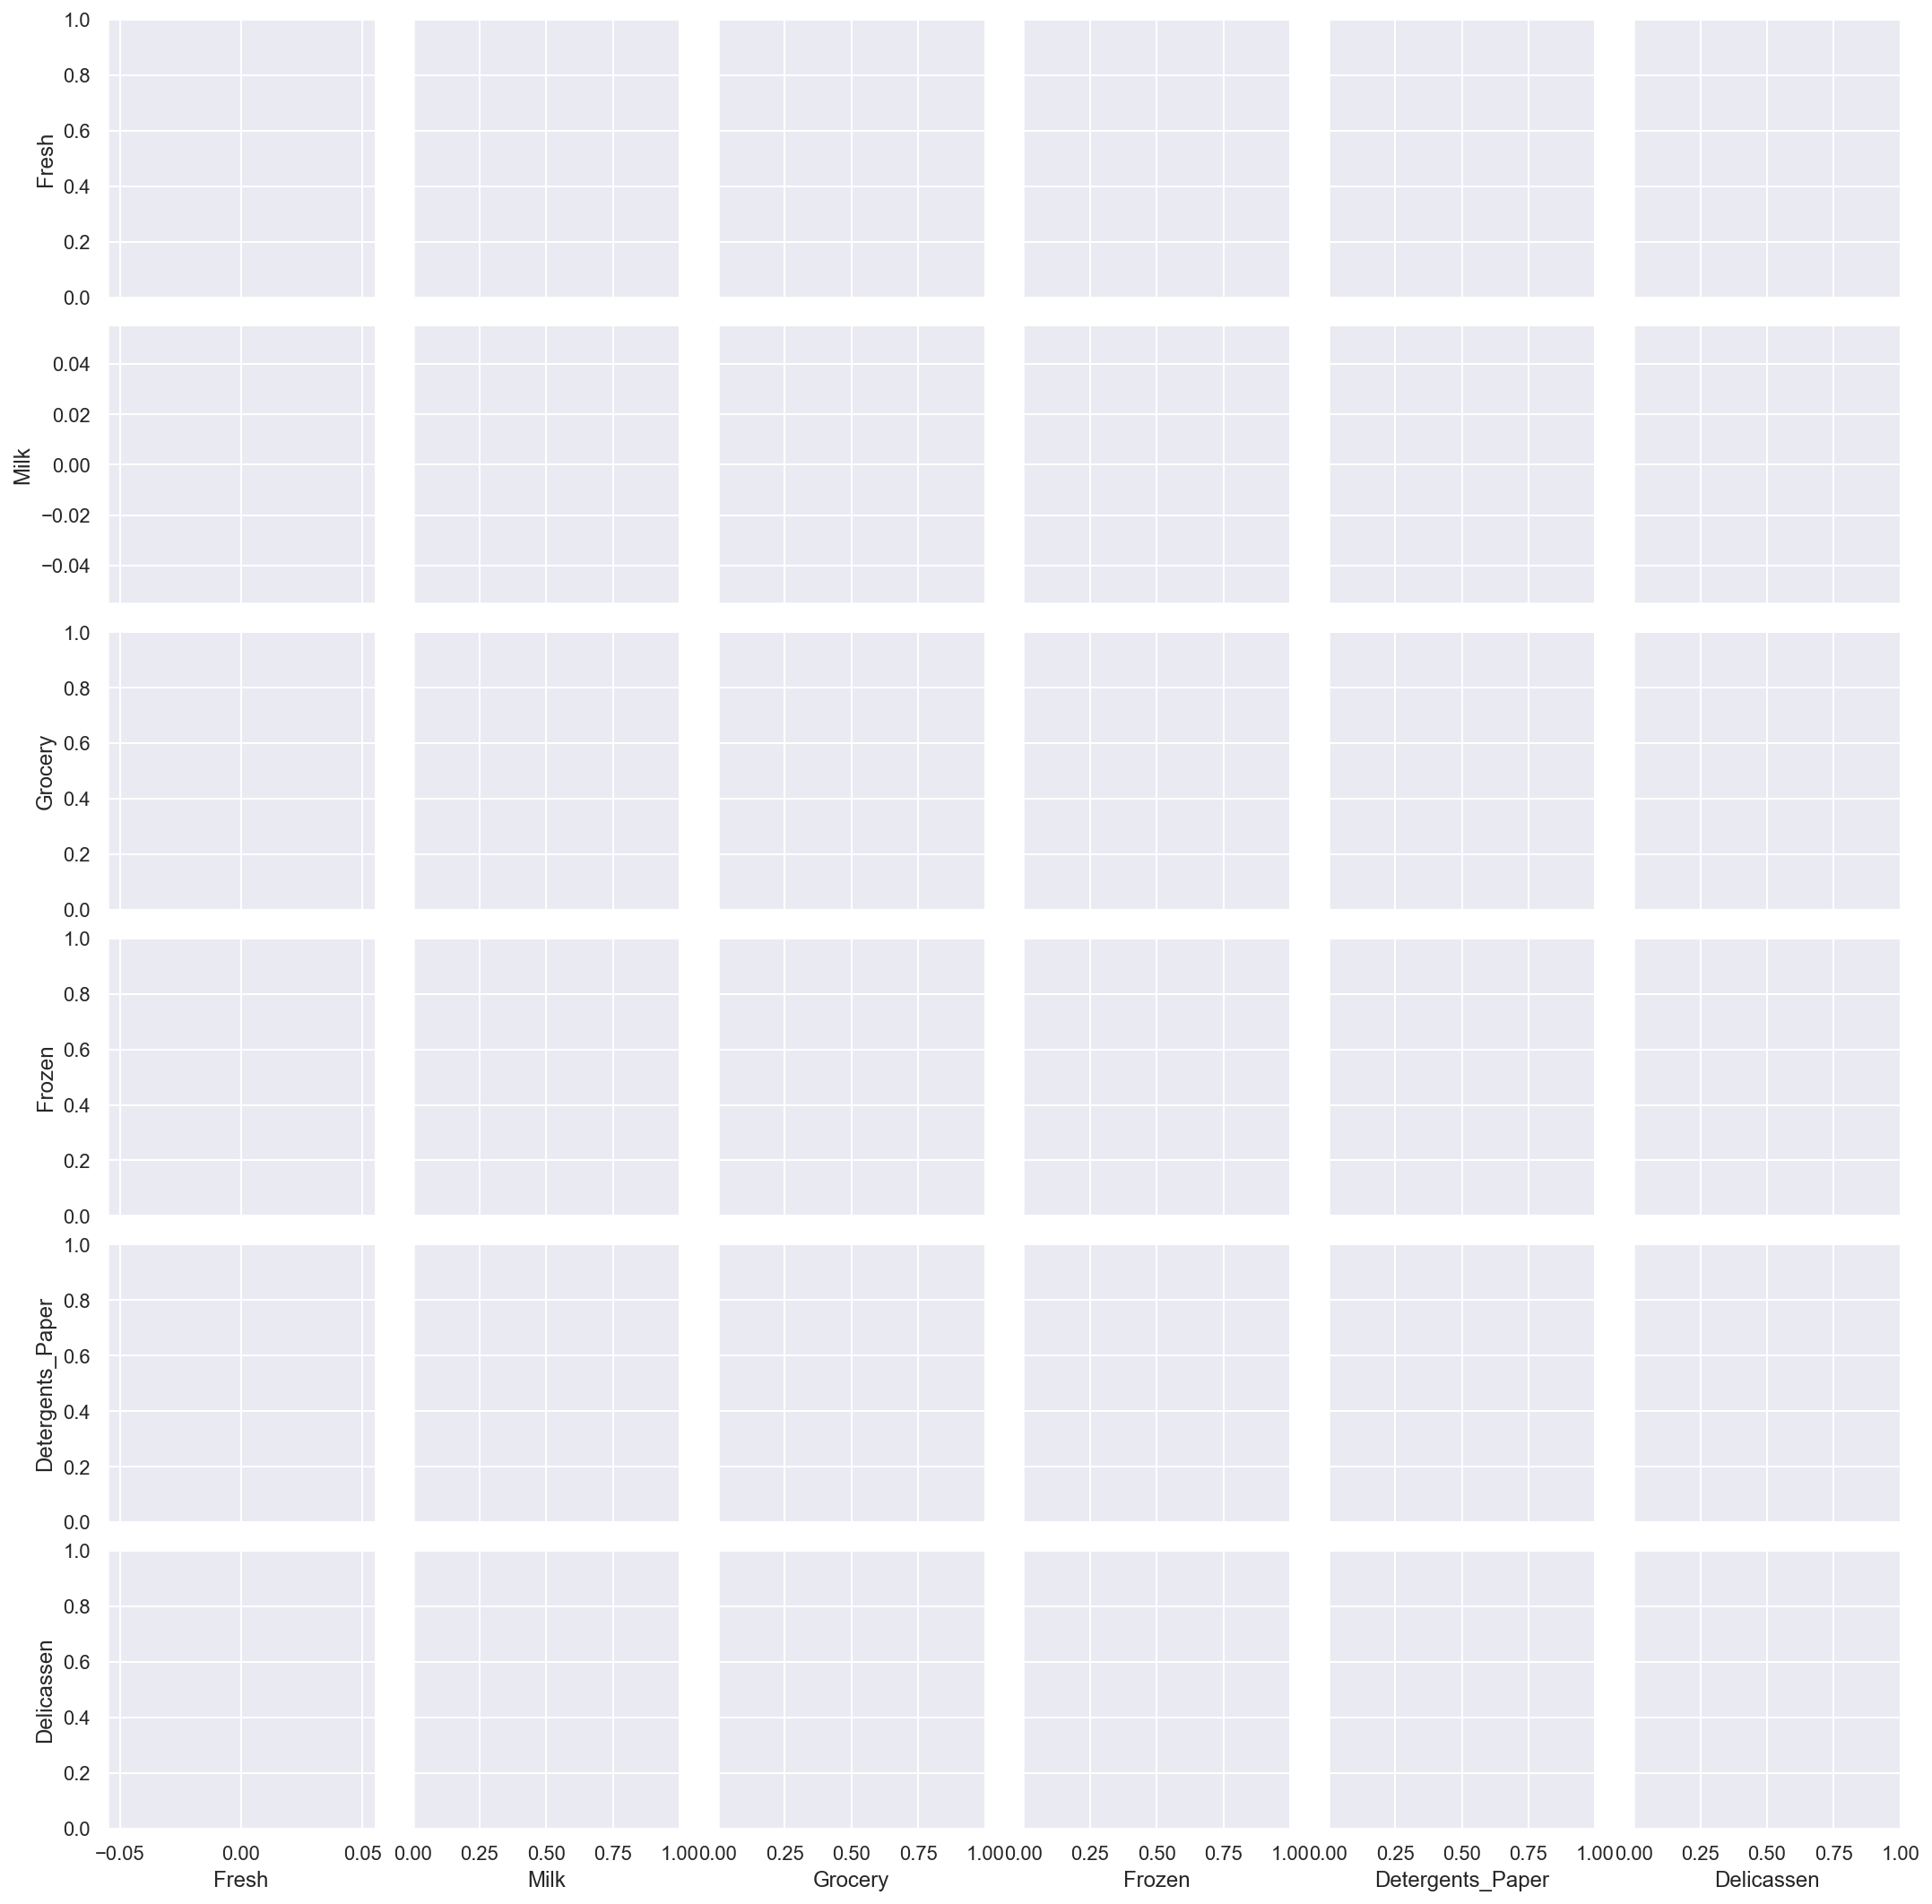

In [39]:
sns.set_context('notebook')
sns.pairplot(data[float_columns + ['Channel']], 
             hue='Channel', 
             hue_order=['1', '2'],
             palette={'1': 'red', '2':'gray'});

In [40]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

km_list = list()

for clust in range(1,21):
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(data[float_columns])
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))

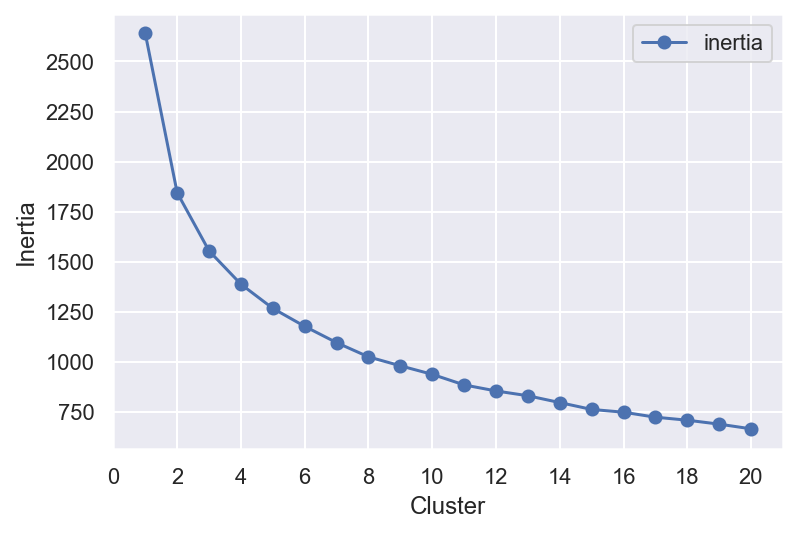

In [43]:
plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,21,2))
ax.set_xlim(0,21)
ax.set(xlabel='Cluster', ylabel='Inertia');

In [44]:
km = KMeans(n_clusters=2, random_state=42)
km = km.fit(data[float_columns])

data['kmeans'] = km.predict(data[float_columns])

In [46]:
(data[['Channel','kmeans']]
 .groupby(['kmeans','Channel'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
kmeans Channel        
0      1            54
       2           134
1      1           244
       2             8

In [47]:
ag = AgglomerativeClustering(n_clusters=2, linkage='ward', compute_full_tree=True)
ag = ag.fit(data[float_columns])
data['agglom'] = ag.fit_predict(data[float_columns])

In [51]:
(data[['Channel','agglom']]
 .groupby(['agglom', 'Channel'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
agglom Channel        
0      1            47
       2           131
1      1           251
       2            11

In [53]:
km = KMeans(n_clusters=3, random_state=42)
km = km.fit(data[float_columns])

data['kmeans10'] = km.predict(data[float_columns])

In [54]:
(data[['Channel','kmeans10']]
 .groupby(['kmeans10','Channel'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
kmeans10 Channel        
0        1           208
         2             3
1        1            34
         2            49
2        1            56
         2            90